## Correct the spectra by redshift and normalize it

In this notebook I'll make plots of the spectra at restframe wavelengths, and later normalize them.

- The wavelength for normalization will be: ??
- The redshift range is: 2.27 to 9.29
- The restframe wavelength range for the whole sample is: 0.048 $\mu m$  to  1.68 $\mu m$
- The overlap range is between 0.15 to 0.53 $\mu m$

In [1]:
## importing libraries
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u
import pandas as pd

In [2]:
hdul = fits.open("deGraaff2025_lrds_withdups_blackbody_eline_fits.fits")
hdul.info()
data = hdul[1].data

files = data["file"]
redshifts = data["zspec"]

#transforming into numpy arrays
files = np.array(files)
redshifts = np.array(redshifts)

print(redshifts.min(), redshifts.max())

spec_info_all = list(zip(files, redshifts))

#removing info from the spectra of program MoM (GO5224) since we don't have its spectra
spec_info_clear = spec_info_all[:59] + spec_info_all[72:]
print(len(spec_info_clear))


Filename: deGraaff2025_lrds_withdups_blackbody_eline_fits.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  PHOT          1 BinTableHDU     94   134R x 32C   [K, K, 24A, 57A, D, D, D, D, D, K, 196A, L, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D, 5D]   
2.2734878 9.294025001594942
121


In [ ]:
## ----------- LIST OF FUNCTIONS --------------
def fnu_to_flambda(fnu, wave, wave_unit="um"):
    """
    Convert F_nu to F_lambda.

    Parameters
    ----------
    fnu : array_like
        Flux density per frequency [erg/s/cm^2/Hz]
    wave : array_like
        Wavelength
    wave_unit : {'um', 'A'}
        Unit of wavelength

    Returns
    -------
    flambda : ndarray
        Flux density per wavelength [erg/s/cm^2/Å]
    """

    c = 2.998e10  # cm/s

    wave = np.asarray(wave)

    if wave_unit == "um":
        lam_cm = wave * 1e-4
    elif wave_unit == "A":
        lam_cm = wave * 1e-8
    else:
        raise ValueError("wave_unit must be 'um' or 'A'")

    return fnu * c / lam_cm**2 / 1e8

def to_restframe(wave, flux, z, flux_type="flambda"):
    """
    Convert spectrum to rest frame.

    Parameters
    ----------
    wave : array_like
        Observed wavelength
    flux : array_like
        Observed flux density
    z : float
        Redshift
    flux_type : {'flambda', 'fnu'}

    Returns
    -------
    wave_rest, flux_rest
    """

    z1 = 1.0 + z
    wave_rest = wave / z1

    if flux_type == "flambda":
        flux_rest = flux * z1
    elif flux_type == "fnu":
        flux_rest = flux / z1
    else:
        raise ValueError("flux_type must be 'flambda' or 'fnu'")

    return wave_rest, flux_rest


def read_spectrum_fits(
    fits_path,
    wave_col="wave",
    flux_col="flux"
):
    """
    Read wavelength and flux from a FITS spectrum.

    Returns
    -------
    wave : ndarray
    flux : ndarray
    """

    with fits.open(fits_path) as hdul:
        data = hdul[1].data
        wave = np.asarray(data[wave_col])
        flux = np.asarray(data[flux_col])

    return wave, flux

def load_spectrum(
    fits_path,
    z=None,
    input_flux_unit="uJy",
    wave_unit="um",
    restframe=True,
    output_flux_scale=None,
):
    """
    Load a spectrum, convert units, and optionally shift to rest frame.

    Returns
    -------
    spectrum : dict
        Keys: wave, flux, z
    """

    wave, flux = read_spectrum_fits(fits_path)

    # ---- Flux unit conversion ----
    if input_flux_unit == "uJy":
        fnu = flux * 1e-29
        flambda = fnu_to_flambda(fnu, wave, wave_unit)
        flux = flambda
        flux_type = "flambda"
    else:
        raise NotImplementedError("Only uJy implemented for now")

    # ---- Rest-frame correction ----
    if restframe and z is not None:
        wave, flux = to_restframe(wave, flux, z, flux_type)

    # ---- Optional scaling (for plotting convenience) ----
    if output_flux_scale is not None:
        flux = flux * output_flux_scale

    return {
        "wave": wave,
        "flux": flux,
        "z": z,
        "file": fits_path
    }

def plot_spectrum_ax(
    ax,
    spectrum,
    title=None,
    show_z=True,
    **plot_kwargs
):
    ax.plot(spectrum["wave"], spectrum["flux"], **plot_kwargs)
    ax.set_ylim(-0.5, 20.5)

    if title:
        ax.set_title(title, fontsize=10)

    if show_z and spectrum["z"] is not None:
        ax.text(
            0.97, 0.95,
            f"z = {spectrum['z']:.3f}",
            transform=ax.transAxes,
            ha="right", va="top",
            fontsize=9,
            bbox=dict(facecolor="white", alpha=0.7, edgecolor="none")
        )

def make_spectrum_panel(
    spec_info,
    loader_kwargs,
    start=0,
    nrows=4,
    ncols=2,
    base_path="DeGraaff_espectros",
):
    """
    spec_info : list of (filename, z)
    loader_kwargs : dict
        Passed directly to load_spectrum
    """

    n_panel = nrows * ncols
    subset = spec_info[start:start + n_panel]

    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(14, 4 * nrows),
        sharex=True, sharey=True
    )
    axes = axes.flatten()

    for ax, (fname, z) in zip(axes, subset):
        spec = load_spectrum(
            f"{base_path}/{fname}",
            z=z,
            **loader_kwargs
        )

        plot_spectrum_ax(ax, spec, title=fname)

    for ax in axes[len(subset):]:
        ax.axis("off")

    fig.supxlabel(r"Wavelength [$\mu$m] (rest frame)")
    fig.supylabel(
        r"Flux [$10^{-20}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$]"
    )

    plt.tight_layout()
    return fig


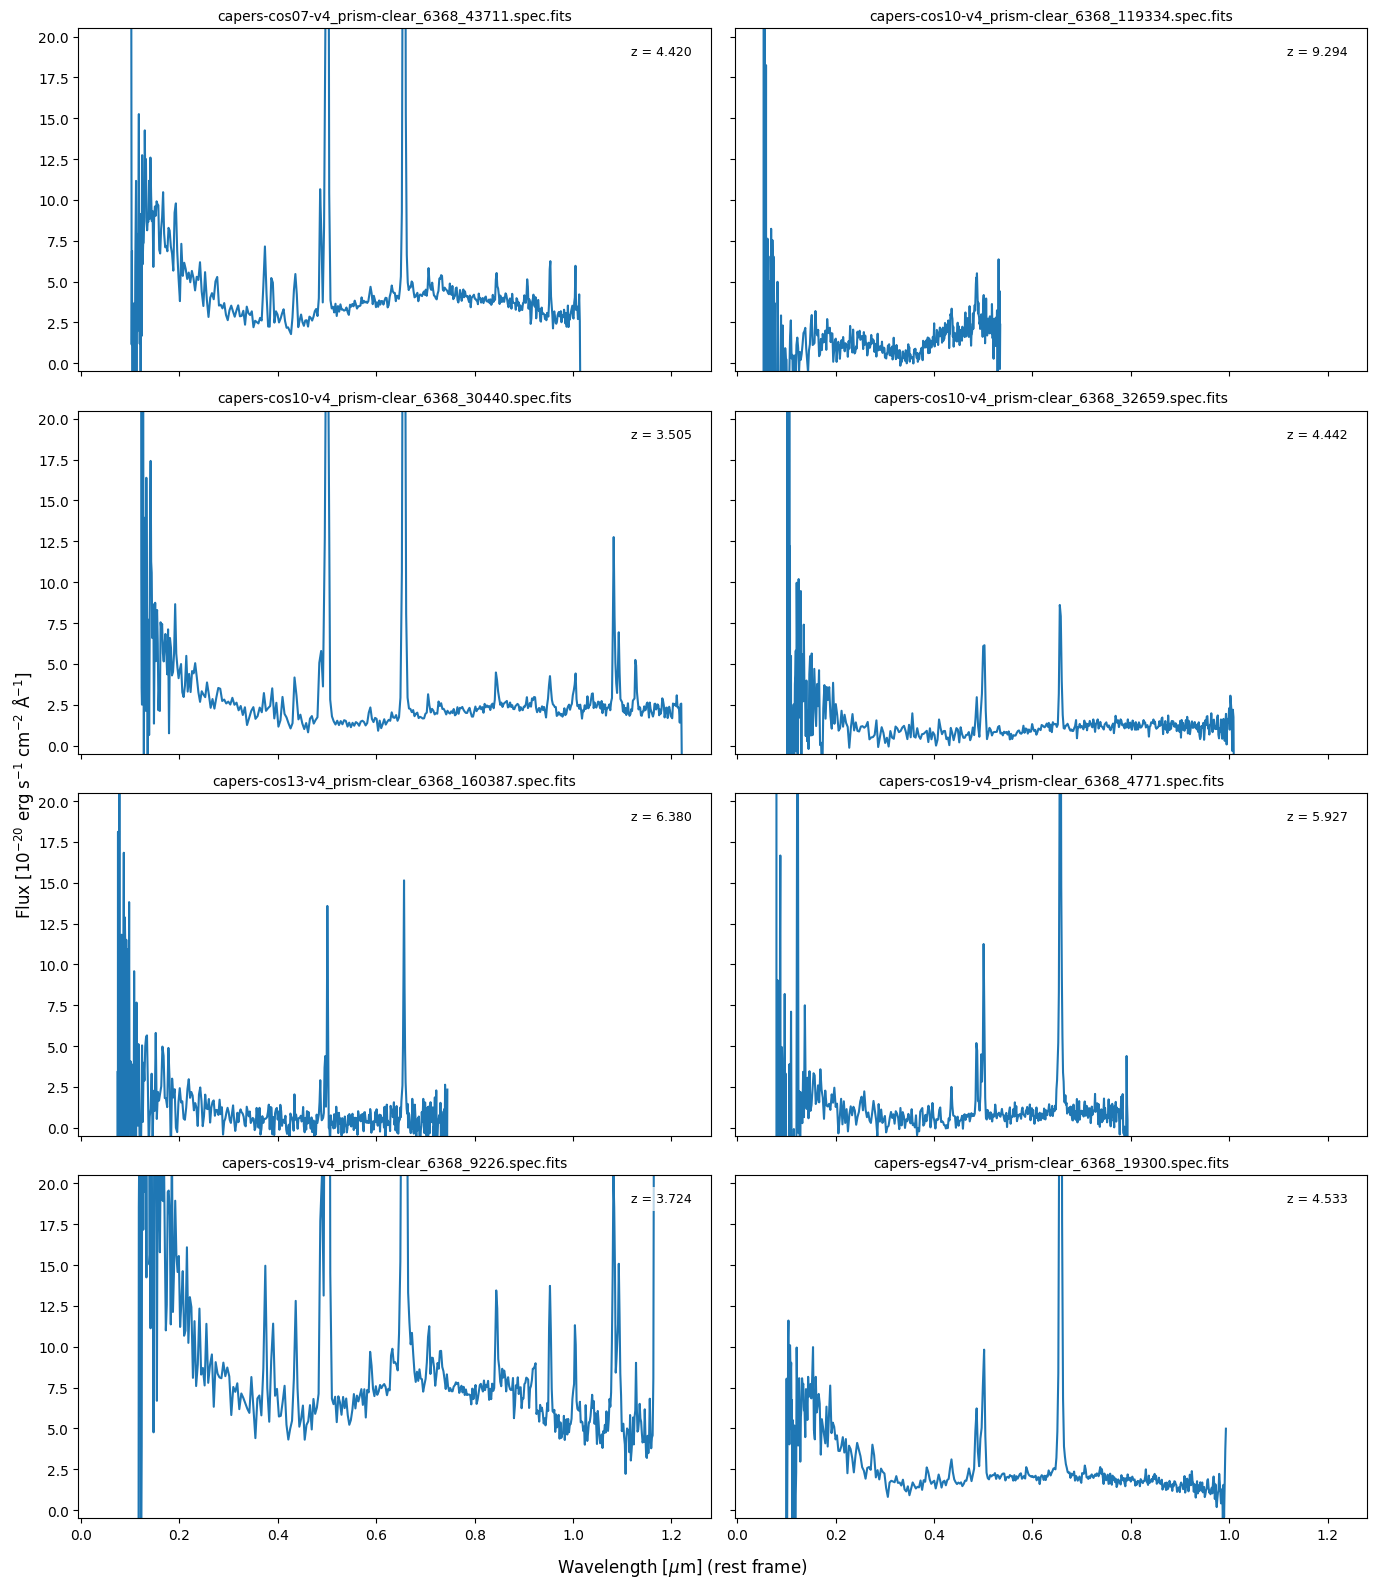

In [37]:
#example of a panel
fig = make_spectrum_panel(
    spec_info_clear,
    loader_kwargs=dict(
        input_flux_unit="uJy",
        wave_unit="um",
        restframe=True,
        output_flux_scale=1e20,
    ),
    start=0
)
